# Datasets Desbalanceados

## 1. Datasets Sintéticos

Vamos a comenzar generando un dataset sintético. La ventaja de este enfoque es que podemos controlar muchas características de este dataset. Por ejemplo, la cantidad de features, si hay features correlacionados o no, la separación entre clases, el desbalanceo, etc.

Vamos a comenzar generando un dataset, que luego separaremos en un dataset medido y en un dataset no medido. De esta forma, simulamos (de una manera muy inocente) el proceso de medición. Esto se podría hacer mejor: en este proceso de medición podríamos agregar ruido, valores mal medidos, etiquetas intercambiadas, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.datasets import make_classification

La siguiente celda genera los datos con los que vamos a trabajar. 

In [43]:
X_real, y_real = make_classification(n_samples=500000,n_features=4, n_informative=4,
                                     n_redundant=0, n_clusters_per_class=1,
                                     class_sep=1.0, weights = [0.99], random_state=40)

Y miramos la cantidad de instancias con etiqueta positiva y qué porcentaje del dataset representa.

In [44]:
print(y_real.sum())
print(y_real.sum()/y_real.size)

7527
0.015054


Pasamos a un DataFrame de Pandas para poder aprovechar algunas funcionalidades de la librería.

In [45]:
df_real = pd.DataFrame()

In [46]:
for i in range(X_real.shape[1]):
    df_real['x' + str(i)] = X_real[:,i]
df_real['y'] = y_real  

Como ya viene mezclado al azar, seleccionar las diez mil primeras instancias es equivalente a muestrear al azar el dataset original.

In [49]:
N = 100000
df_medido = df_real[:N]
df_medido.head()

,x0,x1,x2,x3,y
0,0.220367,1.835091,1.741776,-1.828475,0
1,2.803821,0.168765,-0.243325,-1.046636,0
2,1.269253,-0.007220,-0.695609,0.228051,0
3,1.160494,0.939165,1.135984,-0.873090,0
4,-2.151842,1.698472,2.352327,0.209815,0


Y dejamos el resto de los los datos como instancias 'no medidas'.

In [50]:
df_no_medido = df_real[N:].reset_index(drop = True)
df_no_medido.head()

,x0,x1,x2,x3,y
0,2.087397,1.355379,-0.431120,-1.615746,0
1,-0.962640,2.388972,1.779412,-0.626848,0
2,1.538701,0.246419,1.864231,-2.123197,0
3,1.971646,0.104802,0.672678,-1.027364,0
4,-1.200064,1.215674,1.345168,-0.220490,0


¿Cuántas instancias positivas y qué porcentaje hay en cada dataset?

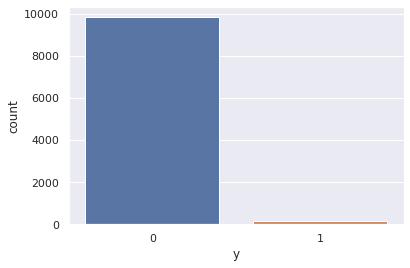

In [9]:
sns.countplot(df_medido.y)

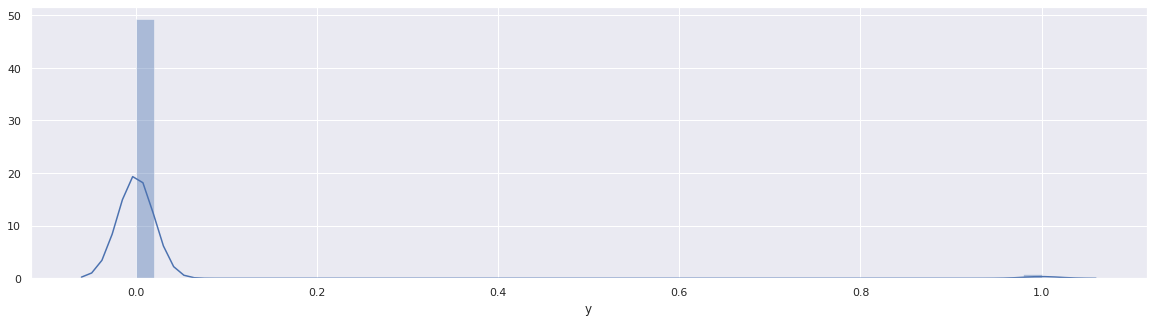

In [10]:
fig  = plt.figure(figsize=(20,5))
sns.distplot(df_medido.y)

In [11]:
print(df_medido.y.sum())
print(df_medido.y.sum()/df_medido.size)

print(df_no_medido.y.sum())
print(df_no_medido.y.sum()/df_no_medido.size)

162
0.00324
1308
0.0029066666666666668


### Exploración de los datos

Miremos cómo es el dataset con el que vamos a trabajar, `df_medido`.

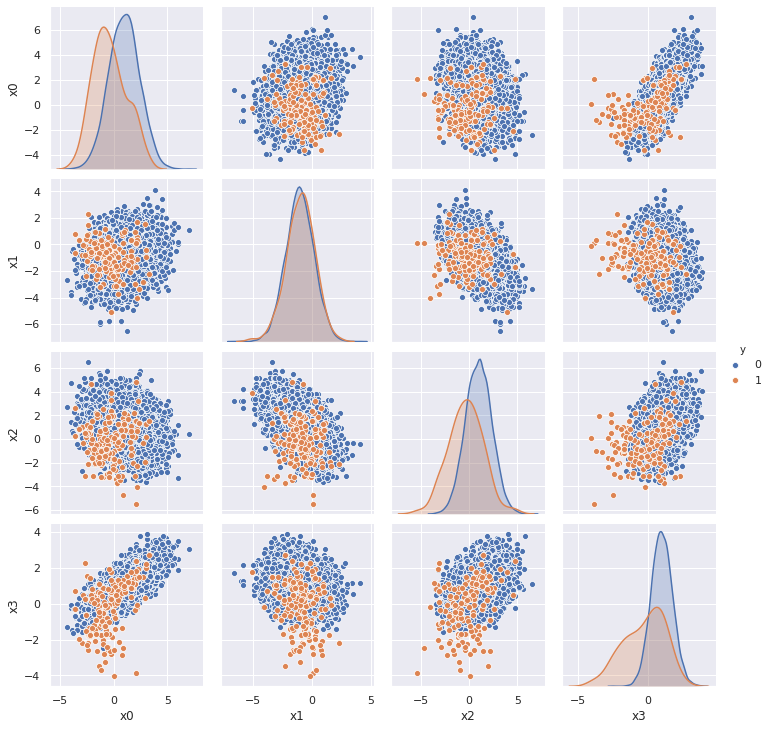

In [104]:
sns.pairplot(data = df_medido, vars = df_medido.columns[:-1], hue = 'y')

Y cómo queda la tabla de correlaciones.

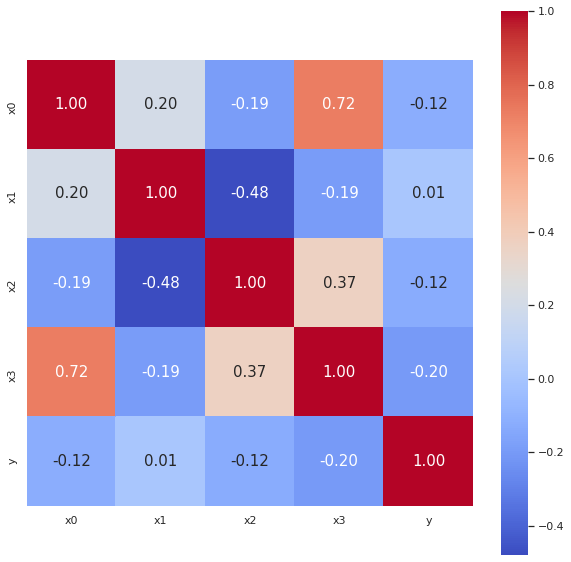

In [105]:
corr = df_medido.corr('pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_medido.columns, 
           yticklabels= df_medido.columns,
           cmap= 'coolwarm')
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
plt.show()

¿Cuáles atributos serán buenos predictores?

**Ejercicio:** Familiarizarse con la función que genera los datos. Cambiar algunos de sus parámetros y volver a correr. 

**Para pensar**: ¿Qué pasa con la tabla de correlaciones a medida que la prevalencia de la clase positiva disminuye?

## 2. Entrenamiento Modelo Uno

Vamos a entrenar un primer modelo de árbol de decisión y evaluarlo usando exactitud. Para ello:

Seleccionamos variables predictoras y etiquetas

In [106]:
X = df_medido.drop('y', axis = 1).values
y = df_medido.y.values

Hacemos un `train_test_split`

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

Observamos cómo son las distribuciones de las variables predictoras

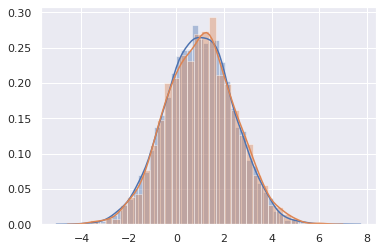

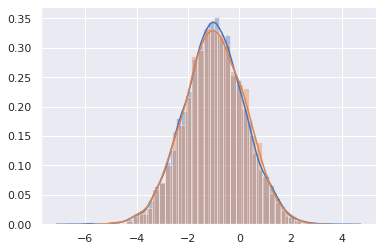

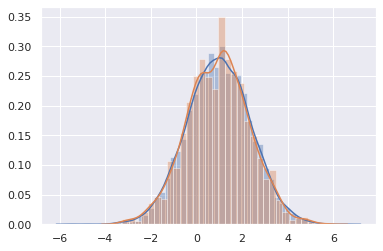

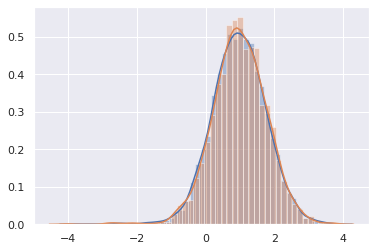

In [108]:
for i in range(X_train.shape[1]):
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Y la proporción de etiquetas positivas en los datos de train y test.

In [109]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.01625
Proporcion de etiquetas positiva en los datos de Test:  0.016


### Entrenamiento del modelo

Vamos a hacer una curva de validación para elegir la mejor profundidad para el árbol de decisión. 

In [110]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [111]:
from sklearn.model_selection import cross_validate

tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad, random_state=42)
    tree_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

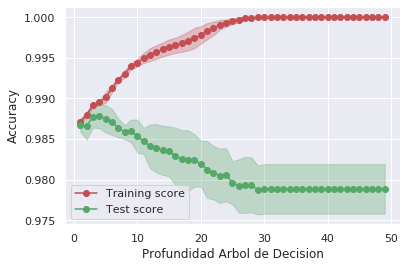

In [112]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.3,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.3, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")


plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¿Cuál profundidad usarían? ¿Cuál es el *benchmark* de este problema?

Entrenemos un árbol de profundidad tres y evaluémoslo en el conjunto de test.

In [113]:
clf_1 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf_1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [114]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_1.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_1.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.989125
Accuracy sobre conjunto de Test: 0.9875


¿Es un buen modelo? Veamos la matriz de confusión en cada conjunto.

In [115]:
(y_train==0).sum(), y_train.sum()

(7870, 130)

In [116]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred, labels=list(set(y)), pos_label=1)

0.5139664804469274

In [117]:
from sklearn.metrics import confusion_matrix

In [118]:
confusion_matrix(y_test, y_test_pred)

array([[1966,    2],
       [  23,    9]])

In [123]:
# ACA

In [124]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1968
           1       0.82      0.28      0.42        32

    accuracy                           0.99      2000
   macro avg       0.90      0.64      0.71      2000
weighted avg       0.99      0.99      0.98      2000



¿Cuáles son sus aciertos, Falsos Positivos y Falsos Negativos?¿Es lo mismo si nos interesa la clase 0 que la clase 1? En el caso de un examen médico, ¿un FP tiene el mismo costo que un FN?

**Ejercicio:** calcular la precisión, exhaustividad (recall) y F-Score de este modelo para cada clase sobre el conjunto de Test. Pueden hacerlo a partir de la matriz de confusión o usando funciones que ya están incorporadas en Scikit-Learn.

In [125]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='micro'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='weighted'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='binary', pos_label = 0))
print(precision_recall_fscore_support(y_test, y_test_pred, average='binary', pos_label = 1))

(0.9033091091914622, 0.6401168699186992, 0.7061433667742182, None)
(0.9875, 0.9875, 0.9875, None)
(0.9857123268887975, 0.9875, 0.9844808434860799, None)
(0.9884364002011061, 0.9989837398373984, 0.9936820823856457, None)
(0.8181818181818182, 0.28125, 0.41860465116279066, None)


### ¿Y si lo ponemos "en producción"?

Una de las ventajas de trabajar con datos sintéticos es que podemos ver cómo desempeñaría nuestro modelo si lo ponemos en producción.

In [126]:
X_no_medido = df_no_medido.drop('y', axis = 1).values
y_no_medido = df_no_medido.y.values

In [127]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_1.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre conjunto de Train: 0.9887111111111111


In [128]:
confusion_matrix(y_no_medido, y_no_medido_pred)

array([[88556,   136],
       [  880,   428]])

**Ejercicio:** medir precisión, exhaustividad y F-Score

In [129]:
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='macro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='micro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='weighted'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='binary', pos_label = 0))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='binary', pos_label = 1))

(0.8745129049847127, 0.6628418644545375, 0.7257805968396106, None)
(0.9887111111111111, 0.9887111111111111, 0.9887111111111111, None)
(0.986799069852716, 0.9887111111111111, 0.9864913818239607, None)
(0.990160561742475, 0.9984666035268119, 0.9942962364142639, None)
(0.7588652482269503, 0.327217125382263, 0.45726495726495725, None)


In [131]:
#ACA 
print(classification_report(y_no_medido, y_no_medido_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     88692
           1       0.76      0.33      0.46      1308

    accuracy                           0.99     90000
   macro avg       0.87      0.66      0.73     90000
weighted avg       0.99      0.99      0.99     90000



**Ejercicio:** repetir para un modelo de vecinos más cercanos.

In [132]:
from sklearn.neighbors import KNeighborsClassifier

In [134]:
knn_train_scores_mean = []
knn_train_scores_std = []
knn_test_scores_mean = []
knn_test_scores_std = []

n_vecinos = np.arange(1,50,1)

for vecinos in n_vecinos:
    clf = KNeighborsClassifier(n_neighbors=vecinos)
    knn_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    knn_train_scores_mean.append(knn_scores['train_score'].mean())
    knn_train_scores_std.append(knn_scores['train_score'].std())
    
    knn_test_scores_mean.append(knn_scores['test_score'].mean())
    knn_test_scores_std.append(knn_scores['test_score'].std())

knn_train_scores_mean = np.array(knn_train_scores_mean)
knn_train_scores_std = np.array(knn_train_scores_std)
knn_test_scores_mean = np.array(knn_test_scores_mean)
knn_test_scores_std = np.array(knn_test_scores_std)

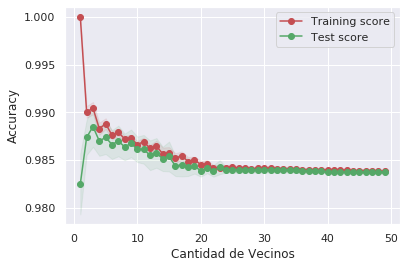

In [135]:
plt.fill_between(n_vecinos, knn_train_scores_mean - knn_train_scores_std,
                 knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(n_vecinos, knn_test_scores_mean - knn_test_scores_std,
                 knn_test_scores_mean + knn_test_scores_std, alpha=0.1, color="g")

plt.plot(n_vecinos, knn_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(n_vecinos, knn_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Cantidad de Vecinos')
plt.show()

In [136]:
clf_1_knn = KNeighborsClassifier()
clf_1_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [137]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_1_knn.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_1_knn.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.9895
Accuracy sobre conjunto de Test: 0.9895


In [138]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[7868,    2],
       [  82,   48]])

In [139]:
confusion_matrix(y_test, y_test_pred)

array([[1967,    1],
       [  20,   12]])

In [140]:
print(precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='micro'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='weighted'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='binary', pos_label = 0))
print(precision_recall_fscore_support(y_test, y_test_pred, average='binary', pos_label = 1))

(0.9565057489063529, 0.6872459349593496, 0.7640117994100295, None)
(0.9895, 0.9895, 0.9895, None)
(0.9888648523092408, 0.9895, 0.9873085545722714, None)
(0.9899345747357826, 0.9994918699186992, 0.9946902654867257, None)
(0.9230769230769231, 0.375, 0.5333333333333333, None)


In [142]:
#ACA
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1968
           1       0.92      0.38      0.53        32

    accuracy                           0.99      2000
   macro avg       0.96      0.69      0.76      2000
weighted avg       0.99      0.99      0.99      2000



Puesta en producción

In [143]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_1_knn.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre conjunto de Train: 0.9891222222222222


In [144]:
confusion_matrix(y_no_medido, y_no_medido_pred)

array([[88614,    78],
       [  901,   407]])

In [145]:
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='macro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='micro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='weighted'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='binary', pos_label = 0))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='binary', pos_label = 1))

(0.9145549527781729, 0.6551413157667169, 0.724247059349641, None)
(0.9891222222222222, 0.9891222222222222, 0.9891222222222222, None)
(0.9877436113550437, 0.9891222222222222, 0.9866508507999527, None)
(0.989934647824387, 0.9991205520227303, 0.9945063886379323, None)
(0.8391752577319588, 0.31116207951070335, 0.4539877300613496, None)


In [146]:
from sklearn.metrics import classification_report

In [147]:
#ACA
print(classification_report(y_no_medido, y_no_medido_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     88692
           1       0.84      0.31      0.45      1308

    accuracy                           0.99     90000
   macro avg       0.91      0.66      0.72     90000
weighted avg       0.99      0.99      0.99     90000



## 3. Balanceando el Dataset

Vamos a balancear el dataset subsampleando la clase más prevalente. Luego, volvemos a analizar los datos y entrenar los modelos.

In [148]:
df_medido.y.sum(), (df_medido.y == 0).sum()

(162, 9838)

In [149]:
df_medido.sample(frac=0.5).shape

(5000, 5)

In [150]:
df_medido[~mask]

,x0,x1,x2,x3,y
0,3.976821,0.372961,-0.650739,2.073284,0
1,1.629085,-1.059597,-1.654043,0.431430,0
2,1.178563,-0.250376,2.329269,1.370564,0
3,1.093868,-1.616160,1.727165,1.464183,0
4,-0.652038,-2.527268,1.589253,1.248053,0
...,...,...,...,...,...
9995,2.905918,-1.457074,1.279754,2.596247,0
9996,1.726818,-0.411497,1.266711,1.685315,0
9997,-0.339344,-0.214555,-0.246459,-0.339800,0
9998,0.604202,0.360246,-0.803878,0.433937,0


In [151]:
mask = df_medido.y == 1

df_subsample = pd.concat([df_medido[mask], df_medido[~mask].sample(n = mask.sum())])

In [152]:
df_subsample.y.sum(), (df_subsample.y == 0).sum()

(162, 162)

In [155]:
df_subsample = df_subsample.sample(frac=1,  random_state=42).reset_index(drop=True)

Hacemos el `pairplot`

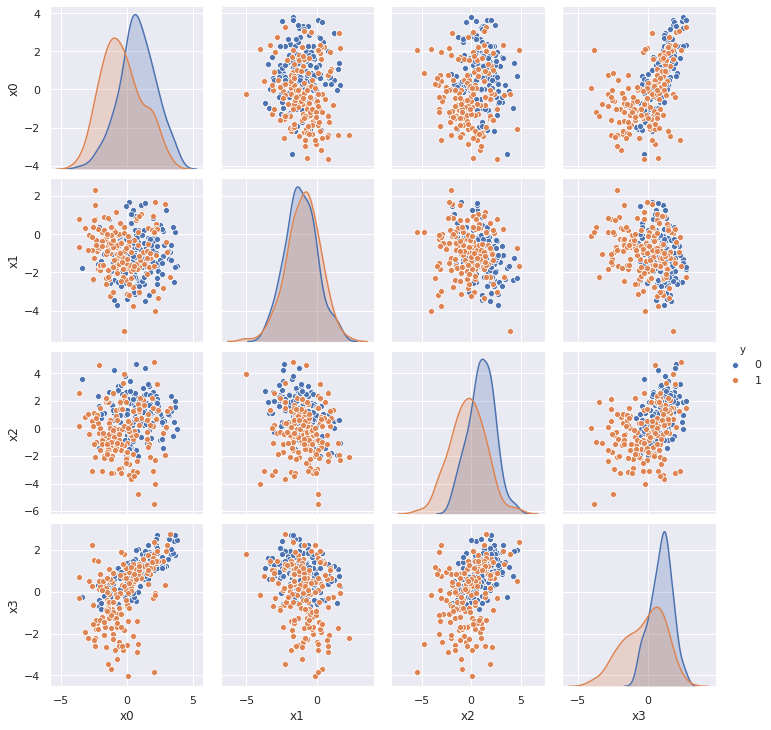

In [154]:
sns.pairplot(data = df_subsample, vars = df_subsample.columns[:-1], hue = 'y')

Y la tabla de correlaciones.

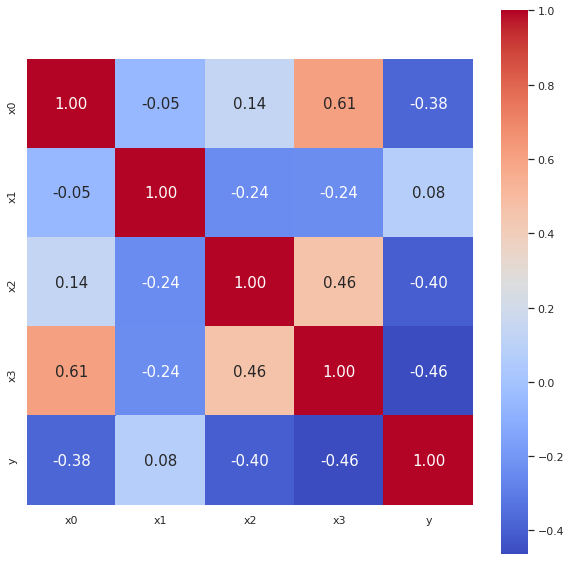

In [156]:
corr = df_subsample.corr('pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_subsample.columns, 
           yticklabels= df_subsample.columns,
           cmap= 'coolwarm')
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
plt.show()

¿Notan algo diferente en la tabla con respecto a la anterior? Si quieren, copien la celda de código de la tabla anterior para poder verlas juntas.

## 4. Entrenamiento Modelo Dos

Seleccionamos variables predictoras y etiquetas

In [157]:
X = df_subsample.drop('y', axis = 1).values
y = df_subsample.y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

Observamos cómo son las distribuciones de las variables predictoras

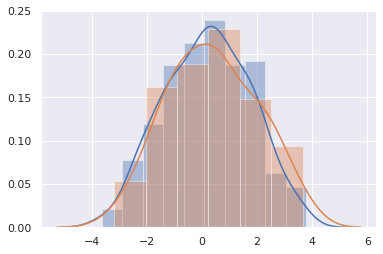

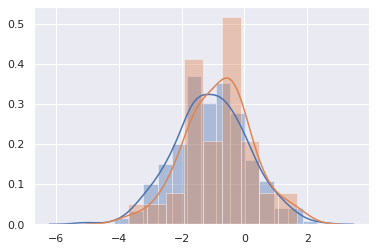

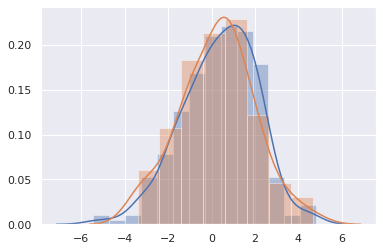

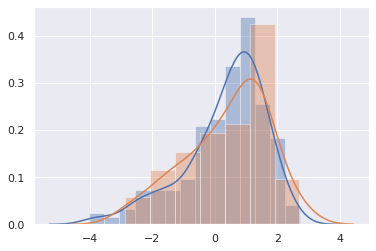

In [159]:
for i in range(X_train.shape[1]):
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

Y la proporción de etiquetas positivas en los datos de train y test.

In [160]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.4980694980694981
Proporcion de etiquetas positiva en los datos de Test:  0.5076923076923077


### Entrenamiento del modelo

Volvemos a hacer la curva de validación.

In [161]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad, random_state=42)
    tree_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

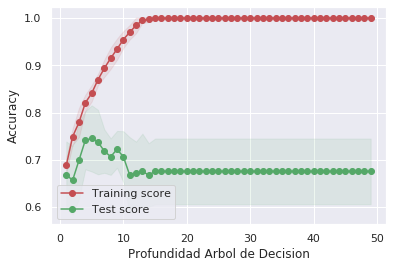

In [162]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")


plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

In [163]:
np.argmax(tree_test_scores_mean)

4

¿Cuál profunidad usarían? Cuál es el *benchmark* de este problema?

Entrenemos un árbol de profundidad tres y evaluémoslo en el conjunto de test.

In [164]:
clf_2 = DecisionTreeClassifier(max_depth = 4, random_state = 42)
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [165]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_2.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_2.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.8223938223938224
Accuracy sobre conjunto de Test: 0.7538461538461538


¿Es un buen modelo? Veamos la matriz de confusión en cada conjunto.

In [166]:
confusion_matrix(y_train, y_train_pred)

array([[127,   3],
       [ 43,  86]])

In [167]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_train, y_train_pred)
print('confusion matrix\n', c_matrix)

tn, fp, fn, tp = c_matrix.ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}')

confusion matrix
 [[127   3]
 [ 43  86]]

TN: 127
FP: 3
FN: 43
TP: 86


In [168]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred, labels=list(set(y)), pos_label=1)

0.7889908256880734

In [169]:
(y_train==0).sum(), y_train.sum()

(130, 129)

In [170]:
confusion_matrix(y_test, y_test_pred)

array([[27,  5],
       [11, 22]])

In [172]:
#ACA
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77        32
           1       0.81      0.67      0.73        33

    accuracy                           0.75        65
   macro avg       0.76      0.76      0.75        65
weighted avg       0.76      0.75      0.75        65



¿Cuáles son sus aciertos, Falsos Positivos y Falsos Negativos?¿Es lo mismo si nos interesa la clase 0 que la clase 1? 

**Ejercicio:** Igual que antes. Calcular la precisión, exhaustividad (recall) y F-Score de este modelo para cada clase sobre el conjunto de Test. Pueden hacerlo a partir de la matriz de confusión o usando funciones que ya están incorporadas en Scikit-Learn.

In [173]:
print(precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='micro'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='weighted'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='binary', pos_label = 0))
print(precision_recall_fscore_support(y_test, y_test_pred, average='binary', pos_label = 1))

(0.7626705653021442, 0.7552083333333333, 0.7523809523809524, None)
(0.7538461538461538, 0.7538461538461538, 0.7538461538461538, None)
(0.763472784525416, 0.7538461538461538, 0.7520879120879121, None)
(0.7105263157894737, 0.84375, 0.7714285714285714, None)
(0.8148148148148148, 0.6666666666666666, 0.7333333333333333, None)


### ¿Y si lo ponemos "en producción"?

In [174]:
X_no_medido = df_no_medido.drop('y', axis = 1).values
y_no_medido = df_no_medido.y.values

In [175]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_2.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre conjunto de Train: 0.9154777777777777


In [176]:
confusion_matrix(y_no_medido, y_no_medido_pred)

array([[81621,  7071],
       [  536,   772]])

¿Qué cambió?¿Es mejor o peor este modelo que el anterior árbol de decisión?

**Ejercicio:** medir precisión, exhaustividad y F-Score

In [177]:
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='macro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='micro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='weighted'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='binary', pos_label = 0))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='binary', pos_label = 1))

(0.5459538142213264, 0.7552443628232866, 0.5621000161452393, None)
(0.9154777777777777, 0.9154777777777777, 0.9154777777777777, None)
(0.9804679304230777, 0.9154777777777777, 0.9440411944219989, None)
(0.9934759058875081, 0.9202746583682857, 0.9554753027527231, None)
(0.09843172255514472, 0.5902140672782875, 0.16872472953775544, None)


In [178]:
print(classification_report(y_no_medido, y_no_medido_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     88692
           1       0.10      0.59      0.17      1308

    accuracy                           0.92     90000
   macro avg       0.55      0.76      0.56     90000
weighted avg       0.98      0.92      0.94     90000



**Ejercicio:** repetir para un modelo de vecinos más cercanos.

In [179]:
from sklearn.neighbors import KNeighborsClassifier

In [180]:
knn_train_scores_mean = []
knn_train_scores_std = []
knn_test_scores_mean = []
knn_test_scores_std = []

n_vecinos = np.arange(1,50,1)

for vecinos in n_vecinos:
    clf = KNeighborsClassifier(n_neighbors=vecinos)
    knn_scores = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    knn_train_scores_mean.append(knn_scores['train_score'].mean())
    knn_train_scores_std.append(knn_scores['train_score'].std())
    
    knn_test_scores_mean.append(knn_scores['test_score'].mean())
    knn_test_scores_std.append(knn_scores['test_score'].std())

knn_train_scores_mean = np.array(knn_train_scores_mean)
knn_train_scores_std = np.array(knn_train_scores_std)
knn_test_scores_mean = np.array(knn_test_scores_mean)
knn_test_scores_std = np.array(knn_test_scores_std)

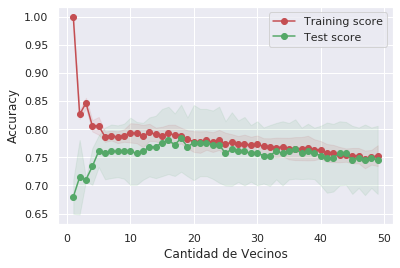

In [181]:
plt.fill_between(n_vecinos, knn_train_scores_mean - knn_train_scores_std,
                 knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(n_vecinos, knn_test_scores_mean - knn_test_scores_std,
                 knn_test_scores_mean + knn_test_scores_std, alpha=0.1, color="g")

plt.plot(n_vecinos, knn_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(n_vecinos, knn_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Cantidad de Vecinos')
plt.show()

In [206]:
np.argmax(knn_test_scores_mean)

17

In [207]:
clf_2_knn = KNeighborsClassifier(n_neighbors=17)
clf_2_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

In [208]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf_2_knn.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = clf_2_knn.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.7992277992277992
Accuracy sobre conjunto de Test: 0.7846153846153846


In [209]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()

In [210]:
tn, fp, fn, tp

(124, 6, 46, 83)

In [211]:
confusion_matrix(y_test, y_test_pred)

array([[30,  2],
       [12, 21]])

In [212]:
print(precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='micro'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='weighted'))
print(precision_recall_fscore_support(y_test, y_test_pred, average='binary', pos_label = 0))
print(precision_recall_fscore_support(y_test, y_test_pred, average='binary', pos_label = 1))

(0.8136645962732919, 0.7869318181818181, 0.7804054054054055, None)
(0.7846153846153846, 0.7846153846153846, 0.7846153846153847, None)
(0.8151935021500238, 0.7846153846153846, 0.77993762993763, None)
(0.7142857142857143, 0.9375, 0.8108108108108109, None)
(0.9130434782608695, 0.6363636363636364, 0.75, None)


Puesta en producción

In [213]:
# Predecimos sobre todas las instancias que no vio
y_no_medido_pred = clf_2_knn.predict(X_no_medido)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_no_medido_pred,y_no_medido))

Accuracy sobre conjunto de Train: 0.9480111111111111


In [214]:
confusion_matrix(y_no_medido, y_no_medido_pred)

array([[84463,  4229],
       [  450,   858]])

In [215]:
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='macro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='micro'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='weighted'))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='binary', pos_label = 0))
print(precision_recall_fscore_support(y_no_medido, y_no_medido_pred, average='binary', pos_label = 1))

(0.5816828415997501, 0.8041407187102919, 0.620691323862356, None)
(0.9480111111111111, 0.9480111111111111, 0.9480111111111111, None)
(0.9826954127292163, 0.9480111111111111, 0.9628061769087672, None)
(0.994700458115954, 0.9523181346682903, 0.9730480112899974, None)
(0.16866522508354628, 0.6559633027522935, 0.2683346364347146, None)


In [216]:
#ACA
print(classification_report(y_no_medido, y_no_medido_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     88692
           1       0.17      0.66      0.27      1308

    accuracy                           0.95     90000
   macro avg       0.58      0.80      0.62     90000
weighted avg       0.98      0.95      0.96     90000



## 5. Dataset de Fraude

Los invitamos a trabajar con este dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

Pueden encontrar un link a un lindo análisis en la presentación de la clase de hoy.

# 6. ROC

Se deben ejecutar las primeras 6/7 celdas de este notebook ( hasta donde se creo *df_no_medido* )

In [51]:
mask = df_medido.y == 1

df_subsample = pd.concat([df_medido[mask], df_medido[~mask].sample(n = mask.sum())])

## DF_Sample

In [52]:
df_subsample.tail()

,x0,x1,x2,x3,y
81762,2.576321,-0.159588,-1.736586,-0.420744,0
54086,0.588238,-0.004484,0.766249,0.266542,0
15746,-2.082402,4.410525,2.957640,-1.812889,0
30571,3.695207,0.459771,-3.733952,-1.172715,0
14416,1.198898,0.295782,-1.181725,1.069200,0


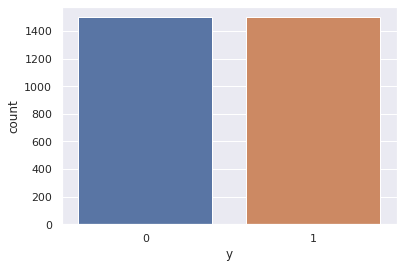

In [53]:
sns.countplot(df_subsample.y)

In [97]:
from sklearn.model_selection import train_test_split


X = df_subsample.drop('y', axis = 1).values
y = df_subsample.y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

### Entrenamos un clasificador para el dataset balancedado

In [98]:
from sklearn.tree import DecisionTreeClassifier

clf_sample = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_sample.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [99]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf_sample.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       300
           1       0.95      0.62      0.75       300

    accuracy                           0.80       600
   macro avg       0.83      0.79      0.79       600
weighted avg       0.83      0.80      0.79       600



In [100]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

Vamos el metodo **predict_proba** este nos va a devolver una columna por cada clase de la columna y del dataframe, con el valor de que la instancia pertenezca a la clase.  
Notar que la matriz tiene la primer columna (la columna 0) para la clase cero del y; la columna 1 para la clase 1.

In [101]:
clf_sample.predict_proba(X_test)[:5]

array([[0.75234043, 0.24765957],
       [0.75700935, 0.24299065],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.75234043, 0.24765957]])

La funcion **roc_auc_score** nos calcula del area bajo la curva roc

In [102]:
roc_auc_score(y_test, clf_sample.predict(X_test))

0.795

La funcion **roc_curve** nos calcula la tasa de falsos positivos y tasa de verdaderos positivos para diferentes umbrales (thresholds) de la clase que le pasemos.  
Nosotres vamos a trabajar con la clase 1 ( con **clf_sample.predict_proba(X_test)[:,1]** le estamos dando la columna de probabilidades de que cada instancia   
                                          sea de la clase 1)

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, clf_sample.predict_proba(X_test)[:,1])

In [104]:
#falsos positivos rate
fpr

array([0.        , 0.        , 0.01      , 0.02      , 0.03333333,
       0.04666667, 0.15      , 0.87      , 1.        ])

In [105]:
#true positivos rate
tpr

array([0.        , 0.11      , 0.59666667, 0.59666667, 0.62333333,
       0.62333333, 0.71666667, 0.95666667, 1.        ])

In [106]:
#umbrales
thresholds

array([2.        , 1.        , 0.99162479, 0.75      , 0.675     ,
       0.44444444, 0.43378995, 0.24765957, 0.24299065])

Ploteamos la curva ROC con los valores fpr, tpr, thresholds

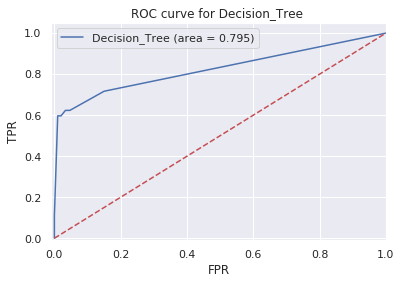

In [107]:
#Obtenemos el area bajo la curva ROC (buscamos que sea carcano a 1, entonces  tenemos 100% de true positive rate y 0% false positive rate)
roc_auc = roc_auc_score(y_test, clf_sample.predict(X_test))

#Obtenemos false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, clf_sample.predict_proba(X_test)[:,1])

#Ploteamos la curva ROC
plt.plot(fpr, tpr, label=f'Decision_Tree (area = {roc_auc:.03f})')
plt.plot([0, 1], [0, 1],'r--')

# Agregamos descripciones al plot
plt.xlim([-0.01, 1.0]), plt.ylim([-0.01, 1.05]), plt.xlabel('FPR'), plt.ylabel('TPR')
plt.title('ROC curve for Decision_Tree ')
plt.legend(loc="upper left")
plt.show()

Comparamos con la matriz de confusion

In [108]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, clf_sample.predict(X_test))

array([[290,  10],
       [113, 187]])

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, clf_sample.predict_proba(X_test)[:,1], )

In [112]:
pd.DataFrame(data={'Umbrales': thresholds, 'TP rate': tpr, 'FP rate': fpr, 'diff(+/-)': tpr-fpr})

,Umbrales,TP rate,FP rate,diff(+/-)
0,2.000000,0.000000,0.000000,0.000000
1,1.000000,0.110000,0.000000,0.110000
2,0.991625,0.596667,0.010000,0.586667
3,0.750000,0.596667,0.020000,0.576667
4,0.675000,0.623333,0.033333,0.590000
5,0.444444,0.623333,0.046667,0.576667
6,0.433790,0.716667,0.150000,0.566667
7,0.247660,0.956667,0.870000,0.086667
8,0.242991,1.000000,1.000000,0.000000


En el df anterior podemos ver a medida que va disminuyendo el umbral el TP rate aumenta y asi como tambien FP rate, buscamos nosotros un punto que nos convenga.

### Df medido

In [113]:
df_medido.tail()

,x0,x1,x2,x3,y
99995,3.527611,-2.658374,0.712090,-0.261943,0
99996,0.425566,1.032462,0.158669,0.157226,0
99997,-1.170421,2.301293,1.881245,-0.917526,0
99998,1.305009,-0.290559,0.310912,-0.211383,0
99999,1.986094,-0.168132,0.945206,-1.462499,0


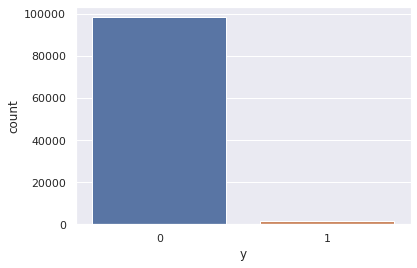

In [114]:
sns.countplot(df_medido.y)

In [115]:
X = df_medido.drop('y', axis = 1).values
y = df_medido.y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [116]:
from sklearn.tree import DecisionTreeClassifier

clf_medido = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_medido.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [117]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf_medido.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19700
           1       0.98      0.40      0.56       300

    accuracy                           0.99     20000
   macro avg       0.98      0.70      0.78     20000
weighted avg       0.99      0.99      0.99     20000



In [118]:
from sklearn.metrics import roc_auc_score, roc_curve

#### Prediccion sobre test

In [74]:
clf_medido.predict_proba(X_test)[:5]

array([[0.99325107, 0.00674893],
       [0.99325107, 0.00674893],
       [0.99325107, 0.00674893],
       [0.99325107, 0.00674893],
       [0.99325107, 0.00674893]])

In [75]:
roc_auc_score(y_test, clf_medido.predict(X_test))

0.6982571912013537

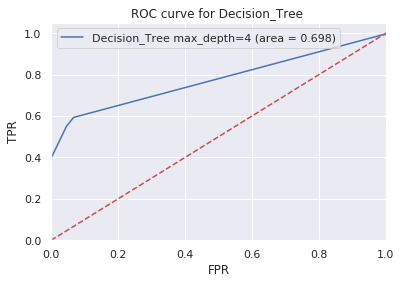

In [76]:
#Obtaining the ROC score
roc_auc = roc_auc_score(y_test, clf_medido.predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, clf_medido.predict_proba(X_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Decision_Tree max_depth=4 (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Decision_Tree ')
plt.legend(loc="upper left")
plt.show()

In [77]:
auc(fpr, tpr)

0.7755054991539764

#### Prediccion sobre df_no medido

In [78]:
X_no_medido = df_no_medido.drop(columns=['y'])
y_no_medido = df_no_medido.y

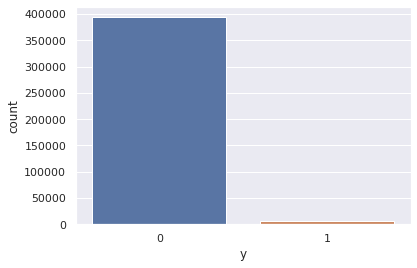

In [79]:
sns.countplot(y_no_medido)

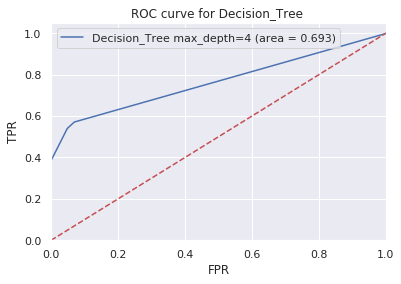

In [80]:
#Obtaining the ROC score
roc_auc = roc_auc_score(y_no_medido, clf_medido.predict(X_no_medido))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_no_medido, clf_medido.predict_proba(X_no_medido)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Decision_Tree max_depth=4 (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Decision_Tree ')
plt.legend(loc="upper left")
plt.show()

---

### Vamos probar dos algoritmos (DecisionTree y LogisticRegression) sobre un nuevo data frame mas balanceado (70% ceros y 30% unos)

### LogisticRegression

In [81]:
X_real, y_real = make_classification(n_samples=1000000, n_features=6, n_informative=5,
                                     n_redundant=1, n_clusters_per_class=3,
                                     class_sep=1.0, weights = [0.7], random_state=40)
df = pd.DataFrame()

for i in range(X_real.shape[1]):
    df['x' + str(i)] = X_real[:,i]
df['y'] = y_real

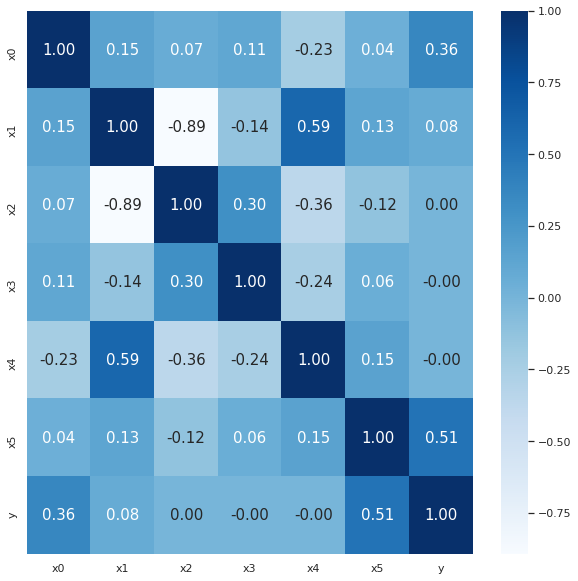

In [82]:
plt.figure(figsize=(10,10))

sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f', annot_kws={'size': 15});

In [83]:
X = df.drop('y', axis = 1).values
y = df.y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [84]:
from sklearn.linear_model import LogisticRegression

In [85]:
lr = LogisticRegression(random_state=42, n_jobs=-1, max_iter=500)
lr.fit(X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [86]:
lr.coef_[0]

array([ 0.90698152,  0.03159012,  0.19945734, -0.15915446,  0.06728778,
        1.53592434])

(-0.3, 1.8)

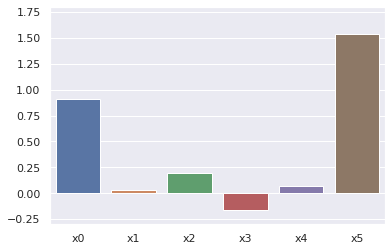

In [87]:
chart = sns.barplot(x=df.columns[:-1].values, y=lr.coef_[0])
chart.axes.set_ylim(-0.3,1.8)

In [88]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93    159398
           1       0.76      0.63      0.69     40602

    accuracy                           0.88    200000
   macro avg       0.83      0.79      0.81    200000
weighted avg       0.88      0.88      0.88    200000



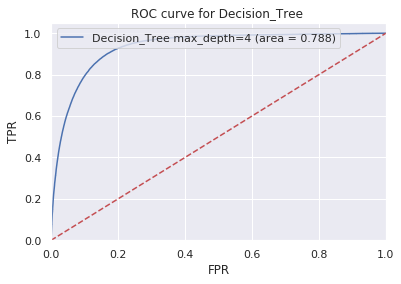

In [89]:
#Obtaining the ROC score
roc_auc = roc_auc_score(y_test, lr.predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Decision_Tree max_depth=4 (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Decision_Tree ')
plt.legend(loc="upper left")
plt.show()

---
#### tree

In [90]:
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [91]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94    159398
           1       0.88      0.54      0.67     40602

    accuracy                           0.89    200000
   macro avg       0.89      0.76      0.80    200000
weighted avg       0.89      0.89      0.88    200000



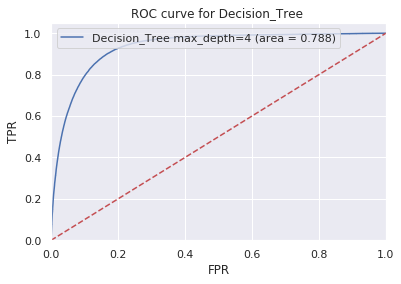

In [92]:
#Obtaining the ROC score
roc_auc = roc_auc_score(y_test, lr.predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Decision_Tree max_depth=4 (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Decision_Tree ')
plt.legend(loc="upper left")
plt.show()